In [40]:
import numpy as np
from sklearn.manifold import TSNE
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import h5py

from pytorch_pretrained_bert import BertTokenizer

from collections import defaultdict

In [41]:
fi_preds = np.load("/u/scr/ethanchi/relationOutputs/fi-en-8/train-pred.npy", allow_pickle=True)
is_adjunct = np.vectorize(lambda x: x and ('PBArgM' in x or 'AM' in x) and '|' not in x and 'R' not in x)
fi_indices = is_adjunct(fi_preds)
fi_preds = fi_preds[fi_indices]
fi_words = np.load("/u/scr/ethanchi/relationOutputs/fi-en-8/train-words.npy", allow_pickle=True)[fi_indices]
fi_words = list(fi_words)

In [42]:
subword_tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
subwords = subword_tokenizer.wordpiece_tokenizer.tokenize(' '.join(fi_words))
subword_mapping = defaultdict(int)
for subword in subwords:
  subword = subword.replace('##', '')
  subword_mapping[subword] += 1
  
print(sorted(subword_mapping.items(), key=lambda kv: -subword_mapping[kv[0]]))

The pre-trained model you are loading is a cased model but you have not set `do_lower_case` to False. We are setting `do_lower_case=False` for you but you may want to check this behavior.


[('ei', 273), ('on', 243), ('ä', 188), ('n', 174), ('voi', 155), ('en', 121), ('t', 115), ('in', 95), ('pu', 87), ('ksi', 82), ('i', 81), ('ole', 77), ('an', 76), ('sti', 73), ('mme', 73), ('jo', 71), ('ky', 70), ('kin', 70), ('än', 70), ('ssa', 69), ('mi', 68), ('a', 67), ('llä', 66), ('ta', 66), ('p', 60), ('si', 59), ('lla', 58), ('yt', 54), ('nyt', 53), ('sa', 53), ('tä', 52), ('y', 51), ('sitten', 49), ('kuitenkin', 48), ('ti', 47), ('k', 46), ('vielä', 45), ('o', 45), ('hu', 43), ('olisi', 42), ('eivät', 42), ('ka', 42), ('ko', 41), ('oli', 41), ('ää', 41), ('hem', 40), ('ies', 40), ('äis', 39), ('la', 38), ('siis', 38), ('pit', 37), ('ki', 37), ('me', 37), ('v', 37), ('ni', 36), ('ike', 36), ('änä', 35), ('sil', 33), ('lo', 33), ('sä', 33), ('myös', 32), ('lle', 31), ('vi', 31), ('itse', 30), ('ku', 30), ('vä', 30), ('yy', 30), ('min', 29), ('vai', 29), ('niin', 28), ('ovat', 28), ('tar', 28), ('esti', 28), ('eles', 27), ('aina', 27), ('se', 26), ('su', 26), ('joten', 26), ('iss

In [43]:
total_subwords = sum(subword_mapping[k] for k in subword_mapping)
print("Total number of subwords is", total_subwords)

Total number of subwords is 12209


In [44]:
en_preds = np.load("/u/scr/ethanchi/relationOutputs/fi-en-8/pred.npy", allow_pickle=True)

is_adjunct = np.vectorize(lambda x: x and ('PBArgM' in x or 'AM' in x) and '|' not in x and 'R' not in x)
en_indices = is_adjunct(en_preds)
en_preds = en_preds[en_indices]
en_words = np.load("/u/scr/ethanchi/relationOutputs/fi-en-8/words.npy", allow_pickle=True)[en_indices]
en_words = list(en_words)


en_logit_file = h5py.File('/u/scr/ethanchi/relationOutputs/fi-en-8/logits.hdf5')
en_logits = en_logit_file.get('logits')[()]
en_logits = en_logits[en_indices]
en_logit_file.close()

en_labels = np.load("/u/scr/ethanchi/relationOutputs/fi-en-8/labels.npy")
en_labels = en_labels[en_indices]


In [45]:
softmax = np.exp(en_logits) / np.sum(np.exp(en_logits), axis=1, keepdims=True)
predicted_prob = softmax[np.arange(len(en_logits)), en_labels.astype(int)]

In [46]:
tokenized = [subword_tokenizer.wordpiece_tokenizer.tokenize(word) for word in en_words]
freq = [sum(subword_mapping[token] for token in token_seq) / (len(token_seq)) for token_seq in tokenized]
freq = np.array(freq)

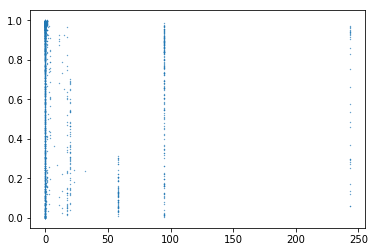

In [47]:
plt.scatter(freq, predicted_prob, s=0.1)

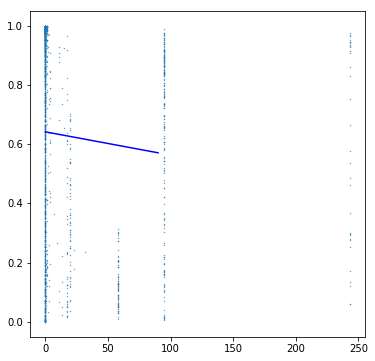

In [48]:
linreg = LinearRegression()
linreg.fit(freq.reshape(-1, 1), predicted_prob)

plt.figure(figsize=(6, 6))

plt.scatter(freq, predicted_prob, s=0.1)
plt.plot(freq_data[:, 0], linreg.predict(freq_data[:, 0].reshape(-1, 1)), color="blue")

(21, 2)


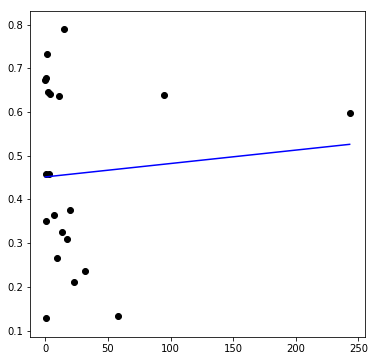

In [49]:
plt.figure(figsize=(6, 6))
freq_data = {}
for possible_freq in np.unique(freq):
  freq_data[possible_freq] = np.average(predicted_prob[freq == possible_freq])

freq_data = np.array([kv for kv in freq_data.items()])
print(freq_data.shape)
plt.scatter(freq_data[:, 0], freq_data[:, 1], c="black")

linreg = LinearRegression()
linreg.fit(freq_data[:, 0].reshape(-1, 1), freq_data[:, 1])

plt.plot(freq_data[:, 0], linreg.predict(freq_data[:, 0].reshape(-1, 1)), color="blue")